In [2]:
# Ticket Dispatch Predictor (Jupyter Notebook)

import json
import joblib
import logging
from typing import Dict, List, Optional
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

# Logging setup
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load JSON ticket data
def load_json_tickets(file_path: str) -> List[Dict]:
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
            return data.get('tickets', [])
    except Exception as e:
        logging.error(f"Error loading JSON file: {str(e)}")
        raise

# Normalize names to match training
def normalize_tech_name(tech: str) -> str:
    if not tech:
        return None
    if 'Carl Labrador' in tech:
        return 'Carl L'
    if 'Carl Tagle' in tech:
        return 'Carl T'
    if 'Michael Barbin' in tech:
        return 'Michael'
    if 'Jomaree Lawsin' in tech:
        return 'Jomaree'
    if 'Jorenzo Lucero' in tech:
        return 'Jorenzo'
    if tech == 'Carl':
        return 'Carl T'
    return tech

# Combine subject + problem type + comment bodies
def prepare_ticket_text(ticket: Dict) -> str:
    text_parts = [ticket.get('subject', ''), ticket.get('problem_type', '')]
    comments = ticket.get('comments', [])
    for comment in comments:
        if comment.get('body'):
            text_parts.append(comment['body'])
    return ' '.join(filter(None, text_parts))

# Load the trained model
def load_model(model_path: str) -> Optional[object]:
    try:
        return joblib.load(model_path)
    except Exception as e:
        logging.error(f"Error loading model: {str(e)}")
        raise

# Predict team member for each ticket
def predict_dispatch(model: object, tickets: List[Dict]) -> tuple:
    texts = [prepare_ticket_text(ticket) for ticket in tickets]
    raw_predictions = model.predict(texts)
    predictions = [normalize_tech_name(pred) for pred in raw_predictions]

    actuals, preds = [], []

    for ticket, prediction in zip(tickets, predictions):
        ticket['predicted_dispatch'] = prediction
        actual_tech = normalize_tech_name(ticket.get('user', {}).get('full_name'))
        if actual_tech:
            ticket['actual_dispatch'] = actual_tech
            actuals.append(actual_tech)
            preds.append(prediction)
        else:
            ticket['actual_dispatch'] = None

    accuracy = accuracy_score(actuals, preds) if actuals else None
    report = classification_report(actuals, preds) if actuals else None

    return tickets, accuracy, report

# === Run the workflow ===

# File paths
ticket_data_path = 'ticket_data_24_Oct.json'
model_path = 'ardence_dispatch_predictor.joblib'

# Load model and data
model = load_model(model_path)
tickets = load_json_tickets(ticket_data_path)

# Predict
tickets_with_predictions, accuracy, report = predict_dispatch(model, tickets)

# Convert to DataFrame for display
df = pd.DataFrame([
    {
        "Ticket #": ticket.get('number'),
        "Subject": ticket.get('subject'),
        "Predicted": ticket.get('predicted_dispatch'),
        "Actual": ticket.get('actual_dispatch'),
        "Correct": ticket.get('predicted_dispatch') == ticket.get('actual_dispatch')
    }
    for ticket in tickets_with_predictions
])

# Show results
df.head(10)  # Show top 10 rows

# Accuracy
if accuracy is not None:
    print(f"\n✅ Overall Accuracy: {accuracy:.2%}")
    print("\n📋 Classification Report:\n")
    print(report)
else:
    print("No actual labels were found for evaluation.")



✅ Overall Accuracy: 92.00%

📋 Classification Report:

              precision    recall  f1-score   support

      Carl L       1.00      0.75      0.86         8
      Carl T       0.88      1.00      0.94        15
     Jomaree       1.00      0.80      0.89         5
     Jorenzo       0.80      0.80      0.80         5
     Michael       0.94      1.00      0.97        17

    accuracy                           0.92        50
   macro avg       0.93      0.87      0.89        50
weighted avg       0.93      0.92      0.92        50



Best hyper-params: {'clf__C': 1, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}

Validation report
               precision    recall  f1-score   support

cybersecurity       0.90      0.90      0.90        10
     hardware       0.91      1.00      0.95        10
microsoft_365       1.00      1.00      1.00        10
   networking       1.00      1.00      1.00        10
   onboarding       1.00      0.90      0.95        10

     accuracy                           0.96        50
    macro avg       0.96      0.96      0.96        50
 weighted avg       0.96      0.96      0.96        50


Test report
               precision    recall  f1-score   support

cybersecurity       0.77      1.00      0.87        10
     hardware       1.00      1.00      1.00        10
microsoft_365       1.00      1.00      1.00        10
   networking       1.00      1.00      1.00        10
   onboarding       1.00      0.70      0.82        10

     accuracy                           0.94        50


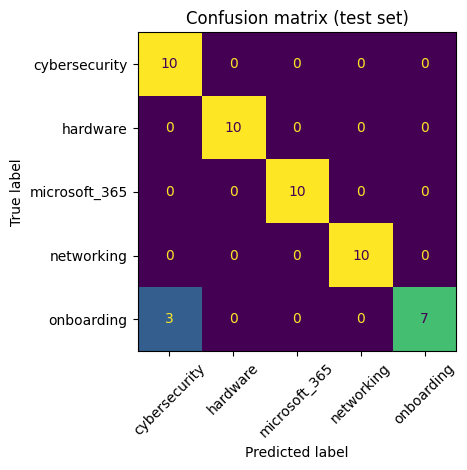


Model saved to ardence_ticket_classifier.joblib


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

# load the cleaned CSV you generated earlier
df = pd.read_csv("syncro_sample_250_tickets.csv")

# split into train/val/test (60/20/20), keeping category balance
X_train_full, X_test, y_train_full, y_test = train_test_split(
    df["ticket_text"],
    df["category"],
    test_size=0.2,
    random_state=42,
    stratify=df["category"]
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.25,
    random_state=42,
    stratify=y_train_full
)

# set up a pipeline: TF-IDF for text → logistic regression for prediction
pipeline = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer(stop_words="english")),
        ("clf", LogisticRegression(max_iter=300, n_jobs=-1))
    ]
)

# try a few hyperparameters for better performance
param_grid = {
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__min_df": [1, 2],
    "clf__C": [0.1, 1, 3]
}

# run grid search with 3-fold cross-validation
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    n_jobs=-1,
    scoring="f1_macro",
    verbose=0
)
grid.fit(X_train, y_train)

# get the best model from the grid search
best_model = grid.best_estimator_
print("Best hyper-params:", grid.best_params_)

# see how it performs on the validation set
print("\nValidation report")
print(classification_report(y_val, best_model.predict(X_val)))

# now test it on the holdout test set
print("\nTest report")
print(classification_report(y_test, best_model.predict(X_test)))

# visualize how it did per category
cm_disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    best_model.predict(X_test),
    display_labels=best_model.classes_,
    xticks_rotation=45,
    colorbar=False
)
plt.title("Confusion matrix (test set)")
plt.tight_layout()
plt.show()

# save the trained model so you can use it later
joblib.dump(best_model, "ardence_ticket_classifier.joblib")
print("\nModel saved to ardence_ticket_classifier.joblib")
